In [114]:
!pip install selenium


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [115]:
!pip install fake_useragent


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import requests
from fake_useragent import UserAgent
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import pandas as pd
from tqdm.auto import tqdm
import time

In [120]:
OUTPUT_FILE = "final_estonian_restaurant_reviews_dataset.csv"

In [121]:
def parse_restaurants_list_block(one_block, website):
    """Extracts restaurant information from a given block of the restaurant list page."""
    restaurant_title_obj = one_block.find('h2', {'class': 'rest-title'})
    if not restaurant_title_obj:
        print("Restaurant title not found")
        return None
    restaurant_name = restaurant_title_obj.find('a').text.strip()
    restaurant_href = restaurant_title_obj.find('a')['href']
    return {
        'website': website,
        'restaurant_name': restaurant_name,
        'restaurant_href': f'https://dinnerbooking.com{restaurant_href}'
    }

In [122]:
def parse_one_restaurant(block):
    """Extracts review details from a restaurant's webpage using Selenium."""
    # Set up Chrome options
    chrome_options = Options()
    chrome_options.add_argument("--headless")  # Run in headless mode
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    chrome_options.add_argument("--user-data-dir=/tmp/chrome-user-data")  # Use a unique temp directory
    
    # Set up the WebDriver
    driver = webdriver.Chrome(options=chrome_options)
    restaurant_reviews = []
    
    try:
        print(f"Opening the web page of the restaurant: {block['restaurant_href']}")
        driver.get(block["restaurant_href"])  # Load the page
        time.sleep(2)  # Wait for elements to load

        # Click "More reviews" until the button disappears (there will be "d-none" class)
        while True:
            try:
                # Try to find the 'More reviews' button
                more_reviews_button = driver.find_element(By.ID, "more-reviews")
                button_class = more_reviews_button.get_attribute("class")

                if "d-none" in button_class:
                    break  # The button is hidden, exit loop

                print("Clicking 'More reviews' button to load more reviews...")
                more_reviews_button.click()
                time.sleep(2)  # Wait for reviews to load
            except:
                break  # No "More reviews" button found, exit loop

        # Extract review blocks and process them
        review_blocks = driver.find_elements(By.CLASS_NAME, "customer-review-area")
        print(f"Number of reviews found: {len(review_blocks)}")

        for review_block in review_blocks:
            try:
                # Extract review author
                review_author = review_block.find_element(By.TAG_NAME, "h4").text.strip().split(' ')[0]
                # Extract review text
                review_text = review_block.find_element(By.CLASS_NAME, "customer-review-description").text.strip()

                def get_rating(label):
                    """Helper function to extract rating value based on label."""
                    try:
                        element = review_block.find_element(By.XPATH, f".//div[contains(text(), '{label}')]/following-sibling::div//div[@class='restaurant-starson']")
                        return float(element.get_attribute("data-rating"))
                    except:
                        return None
                
                review_data = {
                    "website": block["website"],
                    "restaurant_name": block["restaurant_name"],
                    "restaurant_href": block["restaurant_href"],
                    "review_author": review_author,
                    "review_text": review_text,
                    # Extract various review ratings
                    "review_rating_total": get_rating("Kokku"),
                    "review_rating_food": get_rating("Toit"),
                    "review_rating_service": get_rating("Teenindus"),
                    "review_rating_atmosphere": get_rating("Atmosfäär"),
                    "review_rating_overall_impression": get_rating("Üldmulje"),
                    "review_rating_price_quality_ratio": get_rating("Hinna ja kvaliteedi suhe")
                }
                restaurant_reviews.append(review_data)
            except Exception as e:
                # Log errors encountered while parsing a review
                print(f"Error processing a review: {e}")
                
    except Exception as e:
        print(f"Error processing {block['restaurant_href']}: {e}")
    
    finally:
        driver.quit()

    return restaurant_reviews

In [123]:
def get_nth_page(page_number):
    """Fetches and processes the restaurant list page for a given page number."""
    session = requests.session()
    ua = UserAgent()
    
    url = f'https://dinnerbooking.com/ee/et-EE/search/restaurants?page={page_number}'
    req = session.get(url, headers={'User-Agent': ua.random})
    soup = BeautifulSoup(req.text, 'html.parser')

    # Extract website name from logo
    website = soup.find("div", {"id": "logo"}).find("img")["alt"]
    
    restaurant_blocks = soup.find_all("div", class_="restaurant-item-wrap row no-margins")
    print(f"Number of restaurants found on web page {page_number}: {len(restaurant_blocks)}")

    data = []
    for block in restaurant_blocks:
        try:
            # Extract restaurant details
            restaurant_data = parse_restaurants_list_block(block, website)
            if restaurant_data:
                # Extract review details for the restaurant
                restaurant_reviews = parse_one_restaurant(restaurant_data)
                data.extend(restaurant_reviews)          
        except Exception as e:
            # Log errors encountered while processing a restaurant list block
            with open("errors.txt", "a") as f:
                f.write(f"Error processing a restaurant list block: {str(e)}\n")
                
    return data

In [124]:
def run_all(n_pages):
    """Runs the extraction process page by page and saves results immediately to a csv-file."""
    for page in tqdm(range(1, n_pages + 1)):
        try:
            data = get_nth_page(page)
            if data:
                # Convert extracted data to a DataFrame
                df = pd.DataFrame(data)
                df.dropna(subset=["review_author"], inplace=True)  # Deleting rows without reviews
                df.to_csv(OUTPUT_FILE, mode="a", index=False, header=not pd.io.common.file_exists(OUTPUT_FILE))
                print(f"Data from page {page} is saved, {len(df)} reviews in total.")
            else:
                print(f"Page {page}: no data to save.")
        except Exception as e:
            print(f"Error processing page {page}: {e}")
                    
    print("Data collection completed!")

In [125]:
# Run extraction for all pages
run_all(8)

  0%|          | 0/8 [00:00<?, ?it/s]

Number of restaurants found on web page 1: 10
Opening the web page of the restaurant: https://dinnerbooking.com/ee/et-EE/r3913/soo-restaurant
Number of reviews found: 10
Opening the web page of the restaurant: https://dinnerbooking.com/ee/et-EE/r3023/lahepere-villa
Clicking 'More reviews' button to load more reviews...
Clicking 'More reviews' button to load more reviews...
Clicking 'More reviews' button to load more reviews...
Clicking 'More reviews' button to load more reviews...
Clicking 'More reviews' button to load more reviews...
Clicking 'More reviews' button to load more reviews...
Clicking 'More reviews' button to load more reviews...
Clicking 'More reviews' button to load more reviews...
Clicking 'More reviews' button to load more reviews...
Clicking 'More reviews' button to load more reviews...
Clicking 'More reviews' button to load more reviews...
Clicking 'More reviews' button to load more reviews...
Clicking 'More reviews' button to load more reviews...
Clicking 'More revi

In [126]:
df.head()

,website,restaurant_name,restaurant_href,review_author,review_text,review_rating_total,review_rating_food,review_rating_service,review_rating_atmosphere,review_rating_overall_impression,review_rating_price_quality_ratio
0,DinnerBooking,SOO Restaurant,https://dinnerbooking.com/ee/et-EE/r3913/soo-r...,MONIKA,Lihtsalt võrratu! Kõik oli nii hästi läbimõeld...,5.0,5.0,5.0,5.0,5.0,5.0
1,DinnerBooking,SOO Restaurant,https://dinnerbooking.com/ee/et-EE/r3913/soo-r...,VIKTORIA,Üks parimaid restoranikogemusi ja maitseelamus...,5.0,5.0,5.0,5.0,5.0,5.0
2,DinnerBooking,SOO Restaurant,https://dinnerbooking.com/ee/et-EE/r3913/soo-r...,MINNA-MAI,Imeline kogemus. Nii mõnus vibe ja toredad tee...,5.0,5.0,5.0,5.0,5.0,5.0
3,DinnerBooking,SOO Restaurant,https://dinnerbooking.com/ee/et-EE/r3913/soo-r...,TRIIN,"Suurepärane maitseelamus, atmosfäär ja toitude...",5.0,5.0,5.0,5.0,5.0,5.0
4,DinnerBooking,SOO Restaurant,https://dinnerbooking.com/ee/et-EE/r3913/soo-r...,KALLE,"Suurepärane koht nautida häid toite, teenindus...",4.8,5.0,5.0,5.0,5.0,4.0


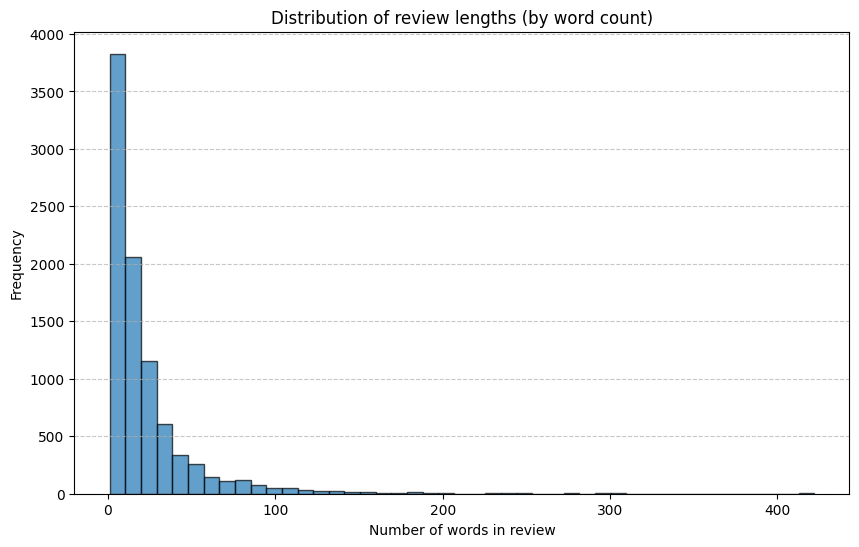

In [22]:
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("final_estonian_restaurant_reviews_dataset.csv")
# Count the number of words in each review
df["review_len"] = df["review_text"].astype(str).apply(lambda x: len(x.split()))

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df["review_len"], bins=45, edgecolor='black', alpha=0.7)
plt.xlabel("Number of words in review")
plt.ylabel("Frequency")
plt.title("Distribution of review lengths (by word count)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

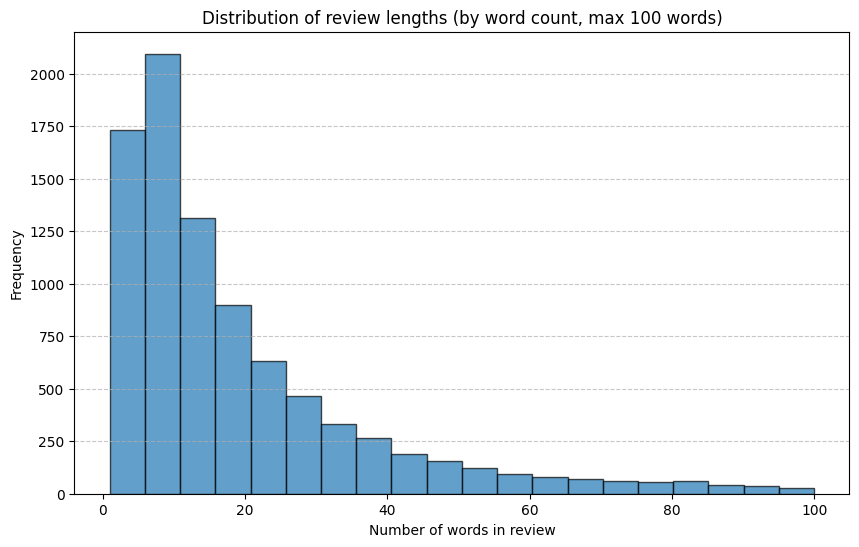

In [145]:
# Filter out reviews longer than 100 words
df = df[df["review_len"] <= 100]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df["review_len"], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Number of words in review")
plt.ylabel("Frequency")
plt.title("Distribution of review lengths (by word count, max 100 words)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [141]:
df["review_rating_total"].value_counts()

5.0    3449
4.8    1333
4.6     821
4.4     595
4.2     497
4.0     487
3.8     295
3.6     193
3.4     163
3.2     162
3.0     158
2.8     147
2.6     123
2.2      98
2.0      98
2.4      92
1.8      79
1.6      56
1.4      26
1.2      23
1.0      22
2.3       6
1.5       6
4.5       6
4.3       5
1.3       3
2.5       2
3.5       2
3.3       1
1.7       1
4.7       1
Name: review_rating_total, dtype: int64

In [15]:
rating_counts = df["review_rating_total"].value_counts()
positive_count = rating_counts[rating_counts.index >= 4].sum()
negative_count = rating_counts[rating_counts.index < 4].sum()

print(f"Reviews with rating >= 4: {positive_count}")
print(f"Reviews with rating < 4: {negative_count}")

Reviews with rating >= 4: 7121
Reviews with rating < 4: 1705


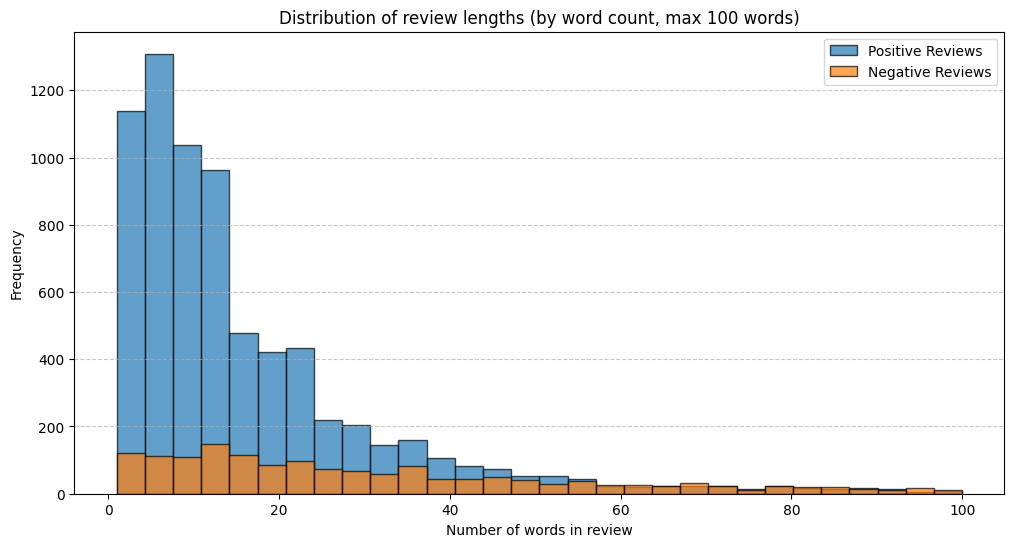

In [149]:
# Separate positive and negative reviews
positive_reviews = df[df["review_rating_total"] >= 4]
negative_reviews = df[df["review_rating_total"] < 4]

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(positive_reviews["review_len"], bins=30, edgecolor='black', alpha=0.7, label="Positive Reviews")
plt.hist(negative_reviews["review_len"], bins=30, edgecolor='black', alpha=0.7, label="Negative Reviews")
plt.xlabel("Number of words in review")
plt.ylabel("Frequency")
plt.title("Distribution of review lengths (by word count, max 100 words)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [1]:
!pip install fasttext


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [23]:
import fasttext

# Creating a test sample

# Drop rows with any missing values
df = df.dropna()

# Load pre-trained fastText language identification model
model = fasttext.load_model("lid.176.bin")

# Function to predict language
def detect_language(text):
    text = text.replace("\n", " ").strip()  # Remove newlines and extra spaces
    lang_code = model.predict(text)[0][0].replace("__label__", "")
    return lang_code if lang_code == "et" else None

# Filter reviews by language (only Estonian)
df["language"] = df["review_text"].astype(str).apply(detect_language)
df = df.dropna(subset=["language"])

# Filter reviews by length (between 20 and 40 words)
filtered_df = df[(df["review_len"] >= 20) & (df["review_len"] <= 40)]

# Split into positive and negative reviews
positive_reviews = filtered_df[filtered_df["review_rating_total"] >= 4]
negative_reviews = filtered_df[filtered_df["review_rating_total"] < 4]

# Determine the required number of reviews
num_negative = int(100 * 0.3)  # 30% negative
num_positive = 100 - num_negative  # 70% positive

# Random sampling of reviews
sample_negative = negative_reviews.sample(n=num_negative, random_state=42)
sample_positive = positive_reviews.sample(n=num_positive, random_state=42)

# Combine the sample
final_test_sample = pd.concat([sample_negative, sample_positive]).sample(frac=1, random_state=42).reset_index(drop=True)

# Save the sample
final_test_sample.to_csv("estonian_restaurant_reviews_test_sample.csv", index=False)

print("Sample successfully saved in 'estonian_restaurant_reviews_test_sample.csv'")

Sample successfully saved in 'estonian_restaurant_reviews_test_sample.csv'


In [30]:
!pip install python-docx


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [31]:
from docx import Document

# Load the test sample reviews CSV
test_sample_df = pd.read_csv("estonian_restaurant_reviews_test_sample.csv")

# Create a new Word document
doc = Document()

# Add reviews to the document with empty lines in between
for review in test_sample_df["review_text"].dropna():
    doc.add_paragraph(review)
    doc.add_paragraph("")  # Empty line for separation

# Save the document
doc.save("estonian_restaurant_reviews_test_sample.docx")

print("Reviews successfully saved in 'estonian_restaurant_reviews_test_sample.docx'")

Reviews successfully saved in 'estonian_restaurant_reviews_test_sample.docx'


In [40]:
test_sample_df = test_sample_df.drop(index=[10, 86], errors='ignore')

rows_to_append = sample_df.loc[[0, 6]]

test_sample_df = pd.concat([test_sample_df, rows_to_append], ignore_index=True)

test_sample_df.to_csv("modified_estonian_restaurant_reviews_test_sample.csv", index=False)

In [19]:
# Load the datasets
final_df = pd.read_csv("final_estonian_restaurant_reviews_dataset.csv")
test_sample_df = pd.read_csv("modified_estonian_restaurant_reviews_test_sample.csv")
final_df.shape

(8950, 11)

In [20]:
test_sample_df.shape

(100, 13)

In [21]:
# Ensure 'review_text' is treated as a string to avoid potential issues
final_df["review_text"] = final_df["review_text"].astype(str)
test_sample_df["review_text"] = test_sample_df["review_text"].astype(str)

# Create a set of review texts from the test sample for quick lookup
test_sample_texts = set(test_sample_df["review_text"].tolist())

# Filter out rows in final_df that have review texts present in the test sample
filtered_final_df = final_df[~final_df["review_text"].isin(test_sample_texts)]

# Save the filtered dataset to a new CSV file
filtered_final_df.to_csv("filtered_final_estonian_restaurant_reviews_dataset.csv", index=False)

In [22]:
filtered_final_df.shape

(8850, 11)

In [23]:
# Creating a validation sample

# Drop rows with any missing values
filtered_final_df = filtered_final_df.dropna()
filtered_final_df["review_len"] = filtered_final_df["review_text"].astype(str).apply(lambda x: len(x.split()))

# Filter reviews by language (only Estonian) using detect_language function written above
filtered_final_df["language"] = filtered_final_df["review_text"].astype(str).apply(detect_language)
filtered_final_df = filtered_final_df.dropna(subset=["language"])

# Filter reviews by length (between 20 and 40 words)
filtered_len_final_df = filtered_final_df[(filtered_final_df["review_len"] >= 20) & (filtered_final_df["review_len"] <= 40)]

# Split into positive and negative reviews
positive_reviews_val = filtered_len_final_df[filtered_len_final_df["review_rating_total"] >= 4]
negative_reviews_val = filtered_len_final_df[filtered_len_final_df["review_rating_total"] < 4]

# Determine the required number of reviews
num_negative_val = int(10 * 0.3)  # 30% negative
num_positive_val = 10 - num_negative_val  # 70% positive

# Random sampling of reviews
sample_negative_val = negative_reviews_val.sample(n=num_negative_val, random_state=42)
sample_positive_val = positive_reviews_val.sample(n=num_positive_val, random_state=42)

# Combine the sample
final_val_sample = pd.concat([sample_negative_val, sample_positive_val]).sample(frac=1, random_state=42).reset_index(drop=True)

# Save the sample
final_val_sample.to_csv("estonian_restaurant_reviews_val_sample.csv", index=False)

print("Sample successfully saved in 'estonian_restaurant_reviews_val_sample.csv'")

Sample successfully saved in 'estonian_restaurant_reviews_val_sample.csv'


In [24]:
final_val_sample.head(10)

,website,restaurant_name,restaurant_href,review_author,review_text,review_rating_total,review_rating_food,review_rating_service,review_rating_atmosphere,review_rating_overall_impression,review_rating_price_quality_ratio,review_len,language
0,DinnerBooking,Gianni,https://dinnerbooking.com/ee/et-EE/r1276/gianni,ANONYMOUS,"Meie laudkonda teenindas noormees, kes oli väg...",5.0,5.0,5.0,5.0,5.0,5.0,26,et
1,DinnerBooking,Gianni,https://dinnerbooking.com/ee/et-EE/r1276/gianni,STEFANIA,Helistasin et lükata oma broneering 18.00st 19...,3.6,4.0,5.0,3.0,3.0,3.0,30,et
2,DinnerBooking,Lahepere Villa,https://dinnerbooking.com/ee/et-EE/r3023/lahep...,MARGE,Tõeline elamusrestoran! Jäime jahiõhtusöögiga ...,4.8,5.0,5.0,5.0,5.0,4.0,36,et
3,DinnerBooking,Ristorante Flavore,https://dinnerbooking.com/ee/et-EE/r1671/risto...,ÜLLE,"Pitsa põhi mustaks kõrbenud.Pakuti küll uut,ag...",2.8,3.0,4.0,3.0,3.0,1.0,26,et
4,DinnerBooking,City Grill House,https://dinnerbooking.com/ee/et-EE/r1669/city-...,JUTA,Tallinnas eriti palju brunchikohti ei tea ja s...,4.0,4.0,4.0,4.0,4.0,4.0,31,et
5,DinnerBooking,Dirhami Kalakohvik,https://dinnerbooking.com/ee/et-EE/r1191/dirha...,ANONYMOUS,Tom Khalt oleks rohkem teravust oodanud. Aga s...,3.8,4.0,4.0,3.0,4.0,4.0,36,et
6,DinnerBooking,Snoob,https://dinnerbooking.com/ee/et-EE/r1782/snoob,ANONYMOUS,Istekohtade broneerimisel palusin laua mängunu...,5.0,5.0,5.0,5.0,5.0,5.0,30,et
7,DinnerBooking,Mon Repos,https://dinnerbooking.com/ee/et-EE/r1102/mon-r...,SANDRA,"Kogu külastus oli väga meeldiv, alates laua br...",5.0,5.0,5.0,5.0,5.0,5.0,33,et
8,DinnerBooking,Tuljak,https://dinnerbooking.com/ee/et-EE/r3833/tuljak,KALMER,Olen väga ammune Tuljaku püsiklient ning võin ...,5.0,5.0,5.0,5.0,5.0,5.0,27,et
9,DinnerBooking,City Grill House,https://dinnerbooking.com/ee/et-EE/r1669/city-...,VALEV,Ootasin rikkalikumat toiduvalikut. Kell 13.00 ...,4.4,3.0,5.0,5.0,5.0,4.0,22,et


In [18]:
# Create a new Word document with reviews for val sample
doc = Document()

# Add reviews to the document with empty lines in between
for review in final_val_sample["review_text"].dropna():
    doc.add_paragraph(review)
    doc.add_paragraph("")  # Empty line for separation

# Save the document
doc.save("estonian_restaurant_reviews_val_sample.docx")

print("Reviews successfully saved in 'estonian_restaurant_reviews_val_sample.docx'")

Reviews successfully saved in 'estonian_restaurant_reviews_val_sample.docx'


In [29]:
# Create a set of review texts from the val sample for quick lookup
val_sample_texts = set(final_val_sample["review_text"].tolist())

# Filter out rows in filtered_final_df that have review texts present in the val sample
filtered_final_df = filtered_final_df[~filtered_final_df["review_text"].isin(val_sample_texts)]

# Save the filtered dataset to a new CSV file
filtered_final_df.to_csv("filtered_final_estonian_restaurant_reviews_dataset.csv", index=False)

In [30]:
filtered_final_df.shape

(7059, 13)